In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
from os import readlink
from pathlib import Path
from astropy.io import fits
import h5py
from copy import deepcopy
from matplotlib import colors
from       matplotlib.widgets        import  Slider


import sys
if sys.path[0]:
    # if ran as a script, append the parent dir to the path
    sys.path.append(os.path.dirname(sys.path[0]))
else:
    # if ran interactively, append the parent manually as sys.path[0] 
    # will be emtpy.
    sys.path.append('..')
sys.path.append('..')
    
# import cosmouline stuff
from config import dbbudir, imgdb, settings, configdir, computer,\
                   psfsfile, extracteddir
from modules.variousfct import proquest, readimagelist, mterror,\
                               backupfile, notify
from modules.kirbybase import KirbyBase
from settings_manager import importSettings

db = KirbyBase(imgdb)  

askquestions = settings['askquestions']
workdir = settings['workdir']
decname = settings['decname']
decnormfieldname = settings['decnormfieldname']
decpsfnames = settings['decpsfnames']
decobjname = settings['decobjname']
refimgname_per_band = settings['refimgname_per_band']
setnames = settings['setnames']

    
# deconvolution identifiers. Lists because one per setname.
deckeyfilenums, deckeynormuseds, deckeys, decdirs,\
           decfiles, decskiplists, deckeypsfuseds, ptsrccats = importSettings('lens')

# the most important one is probably "decfiles", which is a list of hdf5 files (one per setname)
# containing all the data needed for the deconvolution



### Config dir: /scratch/COSMOULINE/ECAM_HE0435-1223/config/ ###


In [2]:
# import starred stuff
from starred.deconvolution.deconvolution import Deconv
from starred.deconvolution.loss import Loss
from starred.utils.optimization import Optimizer
from starred.deconvolution.parameters import ParametersDeconv
from starred.utils.noise_utils import propagate_noise
from starred.plots.plot_function import view_deconv_model

In [3]:
# Parameters
M = 4 # number of point sources 
method = 'trust-constr'
method_ada = 'adabelief'
# lambdas normalized in weight map.
lambda_scales = 1.
lambda_hf = 1.
convolution_method = 'fft'

## Tune background and image positions with best seeing frames

In [4]:
# get data
def getData(decfile):
    with h5py.File(decfile, 'r') as f:
        data = np.array(f['stamps'])
        noisemap = np.array(f['noisemaps'])
        s = np.array(f['psfs'])
    
    im_size = data.shape[1]
    im_size_up = s.shape[1]
    epochs = data.shape[0]
    subsampling_factor = im_size_up // im_size
    
    return data, noisemap, s, (im_size, im_size_up, subsampling_factor, epochs)
        
    

In [5]:
decfiles

['/scratch/COSMOULINE/ECAM_HE0435-1223/dec_R_back1_lens_renorm_1_acd/stamps-noisemaps-psfs.h5']

/tmp/ipykernel_203702/3081153373.py:15: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.colorbar(axs[1].imshow(data[1,:,:]/noisemap[1,:,:]**0.5,


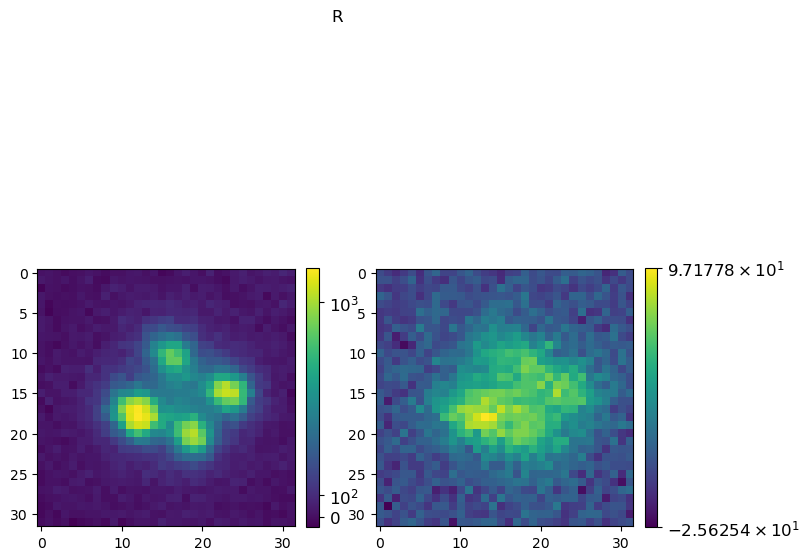

In [6]:
# see the frist two stamps
for setname, decfile in zip(setnames, decfiles):
    data, noisemap, s, (im_size, im_size_up, subsampling_factor, epochs) = getData(decfile)
    fig, axs = plt.subplots(1, 2, figsize=(8,8))
    fraction = 0.046
    pad = 0.04
    plt.suptitle(setname)
    plt.rc('font', size=12)           
    axs[0].tick_params(axis='both', which='major', labelsize=10)
    axs[1].tick_params(axis='both', which='major', labelsize=10)

    fig.colorbar(axs[0].imshow(data[0,:,:],
                               norm=colors.SymLogNorm(linthresh=1e3)),
                               ax=axs[0], fraction=fraction, pad=pad)
    fig.colorbar(axs[1].imshow(data[1,:,:]/noisemap[1,:,:]**0.5,
                               norm=colors.SymLogNorm(linthresh=1e3)), 
                               ax=axs[1], fraction=fraction, pad=pad)
    plt.show()

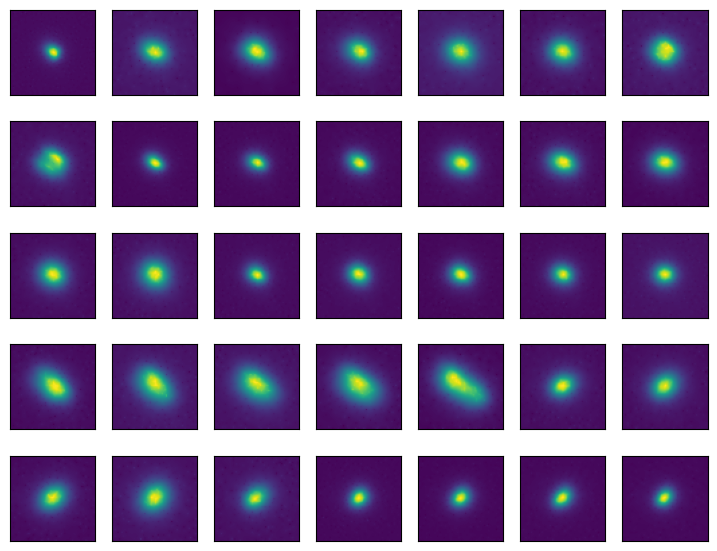

In [8]:
# see some psfs
fig, axs = plt.subplots(5,7, figsize=(9,7))
for im, ax in zip(s, axs.flatten()):
    ax.imshow(im)
    ax.set_xticks([])
    ax.set_yticks([])

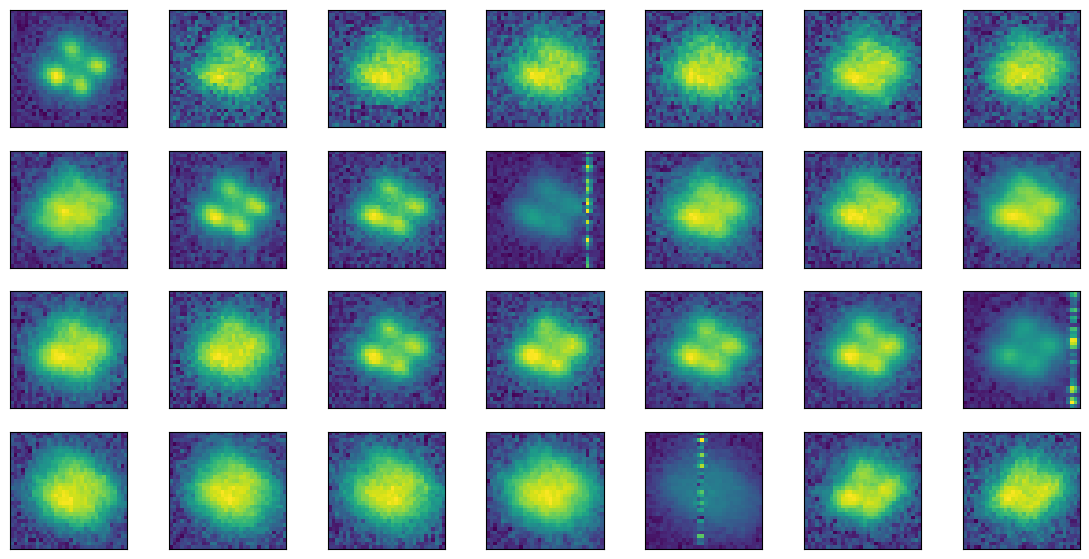

In [9]:
# see some noise maps
fig, axs = plt.subplots(4,7, figsize=(14,7))
for im, ax in zip(noisemap, axs.flatten()):
    ax.imshow(im**0.5)
    ax.set_xticks([])
    ax.set_yticks([])

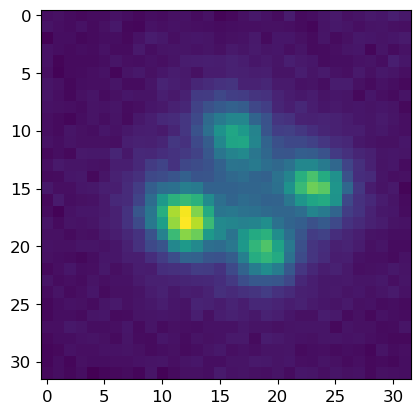

In [10]:
plt.figure()
plt.imshow(data[0,:,:])

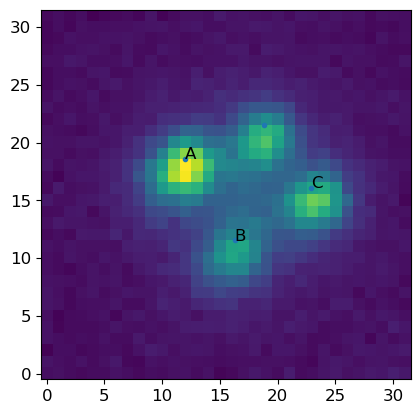

In [13]:
# image positions (read these from a matplotlib plot above)
off = (im_size-1) / 2. # removing im_size / 2 because starred has (0,0) = center
# you will probably need to adjust your offset
xs = np.array([11.95, 16.28, 22.86, 18.79]) 
ys = np.array([18.56, 11.54, 16.05, 21.50])

plt.imshow(data[0,:,:], origin='lower')
plt.plot(xs, ys, '.')
for n, x, y in zip('ABC', xs, ys):
    plt.text(x, y, n)

In [15]:
# Parameter initialization

# image positions (read these from a matplotlib plot above)
off = (im_size-1) / 2. # removing im_size / 2 because starred has (0,0) = center
# you will probably need to adjust your offset
xs = np.array([11.95, 16.28, 22.86, 18.79]) - off
ys = np.array([18.56, 11.54, 16.05, 21.50]) - off

initial_c_x = xs * subsampling_factor 
initial_c_y = ys * subsampling_factor 
# intensity per point:
# adjust these from running this cell iteratively
initial_a = 1.65*np.array(epochs*[20000., 15000., 17000., 17000.])

# no need to do anything past here, setting up the deconv in a standard way.
# provide a normalization for the image, makes things numerically more tractable:
scale = data.max()
initial_a /= scale
# we will also provide the Deconvolution class with this scale at the end of this cell.

# initial background:
initial_h = np.zeros((im_size_up**2))



# dictionary containing the parameters of deconvolution.
# (The translations dx, dy are set to zero for the first epoch.
# Thus we only initialize (epochs-1) of them.)
kwargs_init = {
    'kwargs_analytic': {
                        'c_x': initial_c_x,
                        'c_y': initial_c_y,
                        'dx' : np.ravel([0. for _ in range(epochs-1)]),
                        'dy' : np.ravel([0. for _ in range(epochs-1)]),
                        'a'  : initial_a},
    'kwargs_background': {'h': initial_h,
                          'mean': np.ravel([0. for _ in range(epochs)])},
}
# same as above, providing fixed parameters:
kwargs_fixed = {
    'kwargs_analytic': {
        'c_x': initial_c_x, 
        'c_y': initial_c_y, 
        # 'a'  : initial_a
    },
    'kwargs_background': {'h': initial_h},
}


# boundaries.
kwargs_up = {
    'kwargs_analytic': {'c_x': list(initial_c_x+3),
                        'c_y': list(initial_c_y+3),
                        'dx' : [5 for _ in range(epochs-1)],
                        'dy' : [5 for _ in range(epochs-1)],
                         'a': list([np.inf for i in range(M*epochs)]) 
                       },
    'kwargs_background': {'h': list([np.inf for i in range(0, im_size_up**2)]),
                          'mean': [np.inf for _ in range(epochs)]
                           },
}

kwargs_down = {
    'kwargs_analytic': {'c_x': list(initial_c_x-3),
                        'c_y': list(initial_c_y-3),
                        'dx' : [-5 for _ in range(epochs-1)],
                        'dy' : [-5 for _ in range(epochs-1)],
                         'a': list([0 for i in range(M*epochs)]) },
    'kwargs_background': {'h': list([-np.inf for i in range(0, im_size_up**2)]),
                          'mean': [-np.inf for _ in range(epochs)]
                           },
        }

# Initializing the model
model = Deconv(image_size=im_size, 
               number_of_sources=M, 
               scale=scale, 
               upsampling_factor=subsampling_factor, 
               epochs=epochs, 
               psf=s, 
               convolution_method=convolution_method)

# and the class handling the parameters:
# (fixed or not, boundaries ...)
parameters = ParametersDeconv(model, kwargs_init, 
                              kwargs_fixed, 
                              kwargs_up=kwargs_up, 
                              kwargs_down=kwargs_down)


# first look at what our model is like given our initial guess:
#view_deconv_model(model, kwargs_init, data, noisemap**2)

In [14]:
# compute noise level in starlet space
# MAKE SURE TO USE A NOISEMAP WITHOUT WEIRD THINGS
# (e.g., masked region with huge values)
W = propagate_noise(model, noisemap[1:], kwargs_init, wavelet_type_list=['starlet'], 
                    method='SLIT', num_samples=200, seed=1, likelihood_type='chi2', 
                    verbose=False, upsampling_factor=subsampling_factor)[0]
#plt.figure()
#plt.imshow(W[0])

# HERE CHOOSE THE CELL YOU NEED
either 
- optimize everything at once immediately
- or optimize only point sources
- or opitmize only backgorund

optax.adabelief: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:33<00:00, 31.96it/s]


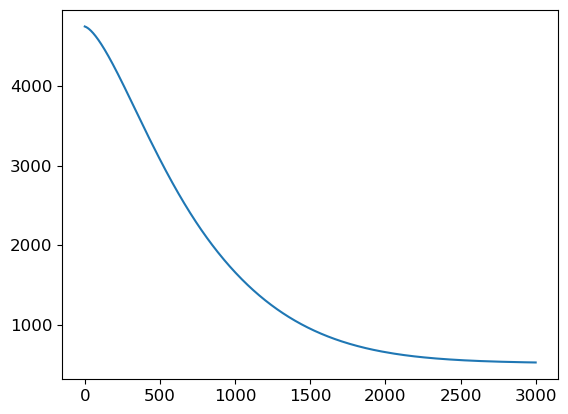

In [16]:
# Point source tuning

kwargs_fixed = {
    'kwargs_analytic': {
    },
    'kwargs_background':  {'h': initial_h},
}

parameters = ParametersDeconv(model, 
                              kwargs_init=kwargs_init, 
                              kwargs_fixed=kwargs_fixed, 
                              kwargs_up=kwargs_up, 
                              kwargs_down=kwargs_down)

loss = Loss(data, model, parameters, noisemap**2, 
            regularization_terms='l1_starlet', 
            regularization_strength_scales=10., 
            regularization_strength_hf=10., W=W) 


optim = Optimizer(loss, parameters, method='adabelief')


optimiser_optax_option = {
                            'max_iterations':3000, 'min_iterations':None,
                            'init_learning_rate':2e-4, 'schedule_learning_rate':True,
                            'restart_from_init':True, 'stop_at_loss_increase':False,
                            'progress_bar':True, 'return_param_history':True
                          }           

best_fit, logL_best_fit, extra_fields, runtime = optim.minimize(**optimiser_optax_option)

kwargs_partial = deepcopy(parameters.best_fit_values(as_kwargs=True))

plt.figure()
plt.plot(extra_fields['loss_history'])
plt.show()


In [13]:
# Background tunning

# here we fix the positions and intensites of point sources,
# and only allow for the background to vary. 
# (pre-requisite: our initial guess is good, so we can just bring up the 
#  background without worrying about the point sources)
#kwargs_fixed = {
#    'kwargs_analytic': {
#        'c_x': initial_c_x, 
#        'c_y': initial_c_y, 
#        'a'  : initial_a
#    },
#    'kwargs_background': {},
#}
#
#parameters = ParametersDeconv(model, 
#                              kwargs_init=kwargs_init, 
#                              kwargs_fixed=kwargs_fixed, 
#                              kwargs_up=kwargs_up, 
#                              kwargs_down=kwargs_down)
#
#loss = Loss(data, model, parameters, noisemap**2, 
#            regularization_terms='l1_starlet', 
#            regularization_strength_scales=1., 
#            regularization_strength_hf=1., W=W) 
#
#optim = Optimizer(loss, parameters, method='adabelief')
#
#
#optimiser_optax_option = {
#                            'max_iterations':9000, 'min_iterations':None,
#                            'init_learning_rate':1e-4, 'schedule_learning_rate':True,
#                            'restart_from_init':True, 'stop_at_loss_increase':False,
#                            'progress_bar':True, 'return_param_history':True
#                          }           
#
#best_fit, logL_best_fit, extra_fields, runtime = optim.minimize(**optimiser_optax_option)
#
#kwargs_partial = deepcopy(parameters.best_fit_values(as_kwargs=True))
#
#
#

In [14]:
#view_deconv_model(model, kwargs_partial, data, noisemap**2)

optax.adabelief: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [01:45<00:00, 38.08it/s]


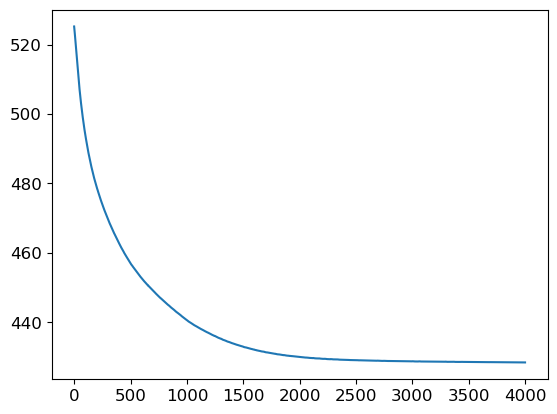

In [17]:
# final tuning: allow everything to be optimized at once.
kwargs_fixed = {
    'kwargs_analytic': {
    },
    'kwargs_background': {},
}

parameters = ParametersDeconv(model, 
                              kwargs_init=kwargs_partial, 
                              kwargs_fixed=kwargs_fixed, 
                              kwargs_up=kwargs_up, 
                              kwargs_down=kwargs_down)

loss = Loss(data, model, parameters, noisemap**2, 
            regularization_terms='l1_starlet', 
            regularization_strength_scales=1.0, 
            regularization_strength_hf=1.0, W=W) 


optim = Optimizer(loss, parameters, method='adabelief')


optimiser_optax_option = {
                            'max_iterations':4000, 'min_iterations':None,
                            'init_learning_rate':5e-3, 'schedule_learning_rate':False,
                            'restart_from_init':True, 'stop_at_loss_increase':False,
                            'progress_bar':True, 'return_param_history':True
                          }           

best_fit, logL_best_fit, extra_fields, runtime = optim.minimize(**optimiser_optax_option)

kwargs_final = deepcopy(parameters.best_fit_values(as_kwargs=True))
# checking how the loss behaved ...
plt.figure()
plt.plot(extra_fields['loss_history'])
plt.show()

In [ ]:
view_deconv_model(model, kwargs_final, data, noisemap**2)

In [17]:
data.shape

(136, 32, 32)

<IPython.core.display.Javascript object>


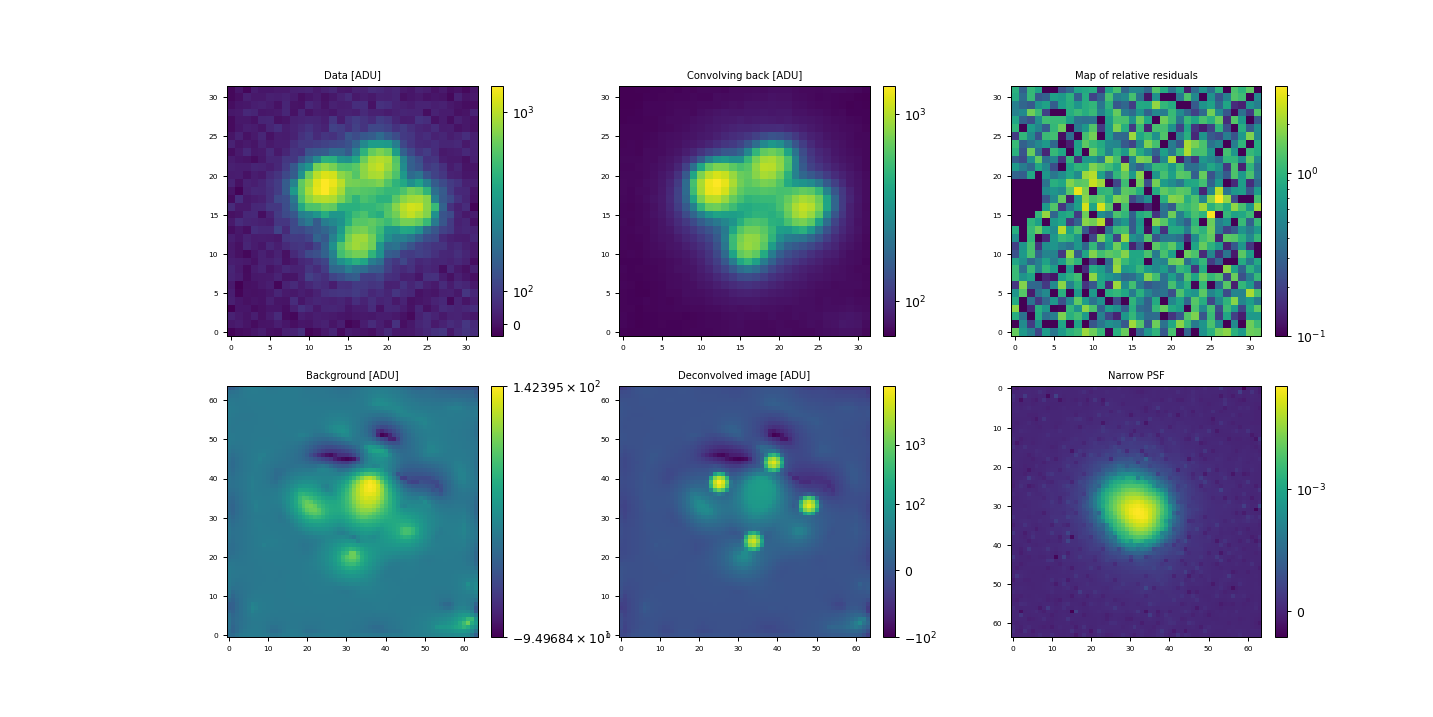

/tmp/ipykernel_181043/1903635585.py:34: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.colorbar(axs[1,0].imshow(h, norm=colors.SymLogNorm(linthresh=5e2), origin='lower'), ax=axs[1,0], fraction=fraction, pad=pad)


In [18]:
# Retrieving different elements of the deconvolved image
epoch = 0
output = model.model(kwargs_final)[epoch] 
deconv, h = model.getDeconvolved(kwargs_final, epoch)

data_show = data[epoch,:,:] 

dif = data_show - output
rr = np.abs(dif) / np.sqrt((noisemap**2)[epoch,:,:])

fig, axs = plt.subplots(2, 3, figsize=(16,8))
fraction = 0.046
pad = 0.04
font_size = 10
ticks_size = 6

plt.rc('font', size=font_size)           
axs[0,0].set_title('Data [ADU]', fontsize=8)
axs[0,0].tick_params(axis='both', which='major', labelsize=ticks_size)
axs[0,1].set_title('Convolving back [ADU]', fontsize=8)
axs[0,1].tick_params(axis='both', which='major', labelsize=ticks_size)
axs[0,2].set_title('Map of relative residuals', fontsize=8)
axs[0,2].tick_params(axis='both', which='major', labelsize=ticks_size)
axs[1,0].set_title('Background [ADU]', fontsize=8)
axs[1,0].tick_params(axis='both', which='major', labelsize=ticks_size)
axs[1,1].set_title('Deconvolved image [ADU]', fontsize=8)
axs[1,1].tick_params(axis='both', which='major', labelsize=ticks_size)
axs[1,2].set_title('Narrow PSF', fontsize=8)
axs[1,2].tick_params(axis='both', which='major', labelsize=ticks_size)

fig.colorbar(axs[0,0].imshow(data_show,origin='lower', norm=colors.SymLogNorm(linthresh=5e2)), ax=axs[0,0], fraction=fraction, pad=pad)
fig.colorbar(axs[0,1].imshow(output,origin='lower', norm=colors.SymLogNorm(linthresh=5e2)), ax=axs[0,1], fraction=fraction, pad=pad) 
fig.colorbar(axs[0,2].imshow(rr,origin='lower', norm=colors.LogNorm(vmin=0.1)), ax=axs[0,2], fraction=fraction, pad=pad) 
fig.colorbar(axs[1,0].imshow(h, norm=colors.SymLogNorm(linthresh=5e2), origin='lower'), ax=axs[1,0], fraction=fraction, pad=pad) 
fig.colorbar(axs[1,1].imshow(deconv, norm=colors.SymLogNorm(linthresh=1e2), origin='lower'), ax=axs[1,1], fraction=fraction, pad=pad) 
fig.colorbar(axs[1,2].imshow(s[epoch,:,:], norm=colors.SymLogNorm(linthresh=1e-3)), ax=axs[1,2], fraction=fraction, pad=pad);

In [19]:
# intensities
A = kwargs_final['kwargs_analytic']['a']
curves = []
for i in range(M):
    curves.append(A[i::M]*model.scale)
    

<IPython.core.display.Javascript object>


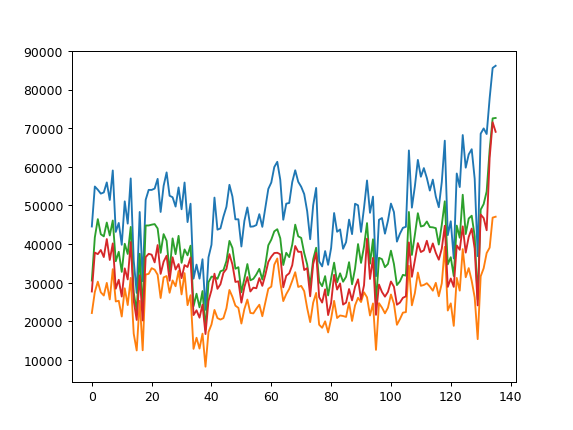

In [20]:
# make sure there's nothing fishy:
plt.figure()
for i in range(M):
    plt.plot(curves[i])
plt.show()

In [23]:
# write the light curves.
with h5py.File(decfile, 'r+') as f:
    if 'light_curves' in f.keys():
        del f['light_curves']
    f['light_curves'] = np.array(curves)